# Bayesian Inference for the Inverse Heat Problem

In [1]:
from helpers import *

In [2]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
from numpy.linalg import inv, solve



plt.rcParams.update({"figure.figsize": (5,4), "font.size": 11})

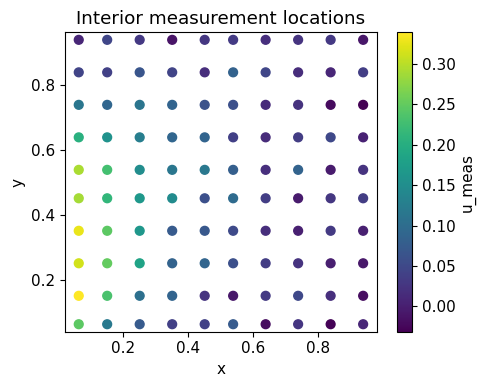

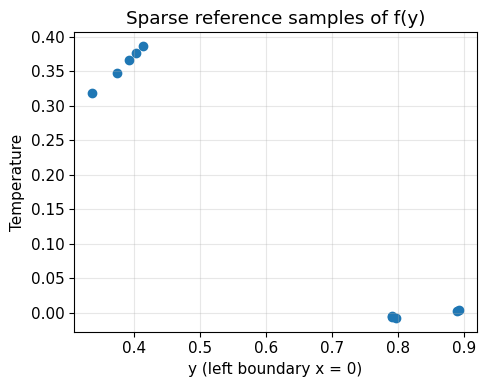

In [3]:
x_meas, y_meas, u_meas, sigma, x_grid, y_grid, f_true_y, f_true_vals = load_data("measurements.npz")
overview_plots(x_meas, y_meas, u_meas, f_true_y, f_true_vals)

## Problem setup and data loading

### Boundary parameterization

We represent the unknown boundary heat flux using radial basis functions (RBFs):

$$
f(y) = \sum_{j=1}^k \alpha_j \exp\left(-\frac{(y - y_j)^2}{2\ell^2}\right)
$$


In [4]:
# Number of RBFs
k = 15

# RBF centers (uniform on boundary)
centres = np.linspace(0, 1, k)

# RBF width (chosen to give overlapping but not redundant bases)
ell = 0.15


In [5]:
x_meas, y_meas, u_meas, sigma, *_ = load_data("measurements.npz")
measurement_points = list(zip(x_meas, y_meas))

m = len(u_meas)  # number of measurements

## Forward model linearization

Although the PDE solver is complex, the forward map is **linear in α**.
We explicitly construct the forward matrix $ G \in \mathbb{R}^{m \times k} $:

$$
G_{ij} = \Phi(e_j)_i
$$

In [6]:
# Required by the blackbox solver
N_blackbox = 40

def build_forward_matrix(k):
    G = np.zeros((m, k))
    for j in range(k):
        alpha = np.zeros(k)
        alpha[j] = 1.0
        G[:, j] = forward_model(alpha, measurement_points, N_blackbox, centres, ell, epsilon=0.03)
    return G

G = build_forward_matrix(k)


## Bayesian model and refined priors

#### Likelihood (given)

We assume i.i.d. Gaussian measurement noise:
$$
u = G\alpha + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2 I)
$$

In [7]:
Sigma_noise = sigma**2 * np.eye(m)


#### Prior (refined)

Instead of a vague prior, we use a **scale-aware Gaussian prior**:

$$
\alpha \sim \mathcal{N}(0, \sigma_\alpha^2 I)
$$


We choose
$$
\sigma_\alpha = 0.5
$$

**Why?:**

* prevents unrealistically large boundary fluxes
* enforces mild smoothness without oversmoothing
* consistent with the magnitude of the observed temperature field

In [8]:
sigma_alpha = 0.5
Sigma_prior = sigma_alpha**2 * np.eye(k)


## Posterior computation

$$
\alpha \mid u \sim \mathcal{N}(\mu_{\text{post}}, \Sigma_{\text{post}})
$$

In [9]:
# Posterior covariance
A = G.T @ inv(Sigma_noise) @ G + inv(Sigma_prior)
Sigma_post = inv(A)

# Posterior mean
mu_post = Sigma_post @ (G.T @ inv(Sigma_noise) @ u_meas)


## Sampling from the posterior

In [10]:
n_samples = 500
alpha_samples = np.random.multivariate_normal(
    mean=mu_post,
    cov=Sigma_post,
    size=n_samples
)


## Boundary reconstruction with uncertainty

In [11]:
y_plot = np.linspace(0, 1, 200)

def eval_boundary(alpha):
    f = np.zeros_like(y_plot)
    for j, yj in enumerate(centres):
        f += alpha[j] * np.exp(-0.5 * ((y_plot - yj) / ell)**2)
    return f


In [12]:
f_mean = eval_boundary(mu_post)

f_samples = np.array([eval_boundary(a) for a in alpha_samples])
f_lower = np.percentile(f_samples, 5, axis=0)
f_upper = np.percentile(f_samples, 95, axis=0)


### Plot 1 – Boundary reconstruction

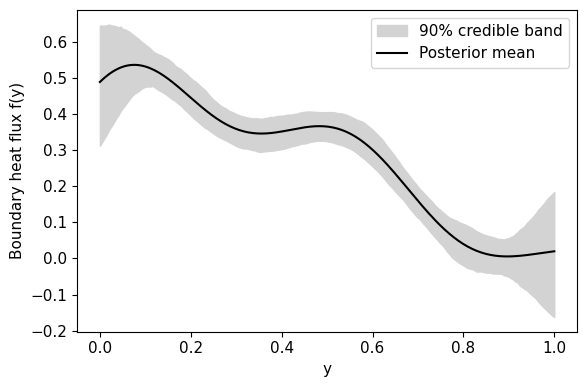

In [13]:
plt.figure(figsize=(6, 4))
plt.fill_between(y_plot, f_lower, f_upper, color="lightgray", label="90% credible band")
plt.plot(y_plot, f_mean, "k", label="Posterior mean")
plt.xlabel("y")
plt.ylabel("Boundary heat flux f(y)")
plt.legend()
plt.tight_layout()
plt.savefig('boundary_reconstruction.png', dpi=300, bbox_inches='tight')
plt.show()

### Plot 2 – Interior data fit

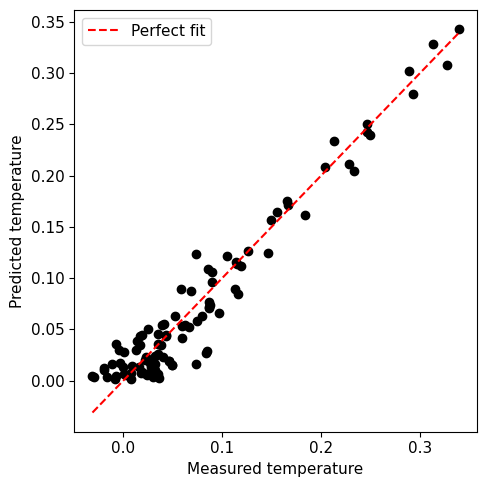

In [14]:
u_pred = G @ mu_post

plt.figure(figsize=(5, 5))
plt.scatter(u_meas, u_pred, c="k")
plt.plot([u_meas.min(), u_meas.max()],
         [u_meas.min(), u_meas.max()],
         "r--", label="Perfect fit")
plt.xlabel("Measured temperature")
plt.ylabel("Predicted temperature")
plt.legend()
plt.tight_layout()
plt.savefig('interior_fit.png', dpi=300, bbox_inches='tight')
plt.show()


### Plot 3 – Posterior uncertainty in coefficients

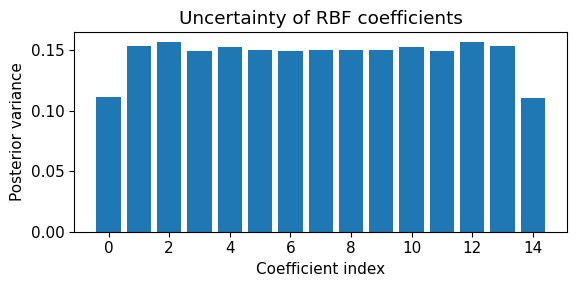

In [15]:
plt.figure(figsize=(6, 3))
plt.bar(range(k), np.diag(Sigma_post))
plt.xlabel("Coefficient index")
plt.ylabel("Posterior variance")
plt.title("Uncertainty of RBF coefficients")
plt.tight_layout()
plt.savefig('posterior_variance.png', dpi=300, bbox_inches='tight')
plt.show()
